In [15]:
pwd

'D:\\Upwork\\MLdeploy\\NYC_TAXI_DEMAND_FORECAST-main'

In [16]:
cd ..

D:\Upwork\MLdeploy


In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import src.config as config

In [19]:
import hopsworks

# connect to the project
project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME,
    api_key_value=config.HOPSWORKS_API_KEY
)

# connect to the feature store
feature_store = project.get_feature_store()

# connect to the feature group
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION,
)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/106655
Connected. Call `.close()` to terminate connection gracefully.


In [20]:
# create feature view (if it doesn't exist yet)
# This feature view only uses on feature group, so the query is trivial
try:
    # create feature view if it doesn't exist yet
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all()
    )
except:
    print('Feature view already existed. Skip creation.')


# get feature view
feature_view = feature_store.get_feature_view(
    name=config.FEATURE_VIEW_NAME,
    version=config.FEATURE_VIEW_VERSION
)

Feature view already existed. Skip creation.


In [21]:
ts_data, _ = feature_view.training_data(
    description='Time-series hourly taxi rides',
)

2023-09-24 19:52:58,258 INFO: USE `uber_demand_featurestore`
2023-09-24 19:52:58,879 INFO: SELECT `fg0`.`pickup_hour` `pickup_hour`, `fg0`.`rides` `rides`, `fg0`.`pickup_location_id` `pickup_location_id`
FROM `uber_demand_featurestore`.`taxi_time_series_hourly_feature_group_2` `fg0`
WHERE `fg0`.`pickup_hour` >= TIMESTAMP '1970-01-01 12:16:40.000' AND `fg0`.`pickup_hour` < TIMESTAMP '2023-09-24 03:52:56.000'


C:\Users\venom\AppData\Local\pypoetry\Cache\virtualenvs\src-CLhNLgNF-py3.9\lib\site-packages\hsfs\engine\python.py:115: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\venom\AppData\Local\pypoetry\Cache\virtualenvs\src-CLhNLgNF-py3.9\lib\site-packages\hsfs\feature_view.py:1450: VersionWarning:

Incremented version to `5`.



In [22]:
ts_data.sort_values(by=['pickup_location_id', 'pickup_hour'], inplace=True)
ts_data

,pickup_hour,rides,pickup_location_id
79678,2023-01-04 19:00:00,0,1
122634,2023-01-04 20:00:00,0,1
5751,2023-01-04 21:00:00,0,1
278037,2023-01-04 22:00:00,0,1
4092,2023-01-04 23:00:00,1,1
...,...,...,...
160368,2023-09-23 23:00:00,2,265
159595,2023-09-24 00:00:00,4,265
349343,2023-09-24 01:00:00,7,265
210785,2023-09-24 02:00:00,4,265


C:\Users\venom\AppData\Local\pypoetry\Cache\virtualenvs\src-CLhNLgNF-py3.9\lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



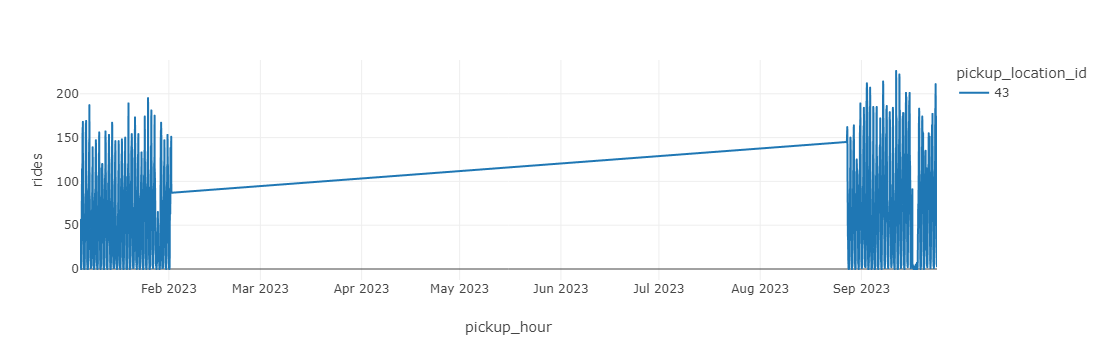

In [23]:
# from src.plot import plot_ts
from typing import Optional, List
import pandas as pd
import plotly.express as px 

def plot_ts(
    ts_data: pd.DataFrame,
    locations: Optional[List[int]] = None
    ):
    """
    Plot time-series data
    """
    ts_data_to_plot = ts_data[ts_data.pickup_location_id.isin(locations)] if locations else ts_data

    fig = px.line(
        ts_data_to_plot,
        x="pickup_hour",
        y="rides",
        color='pickup_location_id',
        template='none',
    )

    fig.show()

plot_ts(ts_data, locations=[43])

In [24]:
from src.data import transform_ts_data_into_features_and_target

features, targets = transform_ts_data_into_features_and_target(
    ts_data,
    input_seq_len=24*28, # one month
    step_size=23,
)

features_and_target = features.copy()
features_and_target['target_rides_next_hour'] = targets

print(f'{features_and_target.shape=}')

  0%|                                                                                            | 0/265 [00:00<?, ?it/s]D:\Upwork\MLdeploy\NYC_TAXI_DEMAND_FORECAST-main\src\data.py:240: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\venom\AppData\Local\pypoetry\Cache\virtualenvs\src-CLhNLgNF-py3.9\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

D:\Upwork\MLdeploy\NYC_TAXI_DEMAND_FORECAST-main\src\data.py:240: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before per

features_and_target.shape=(7685, 675)


In [25]:
features_and_target

,rides_previous_672_hour,rides_previous_671_hour,rides_previous_670_hour,rides_previous_669_hour,rides_previous_668_hour,rides_previous_667_hour,rides_previous_666_hour,rides_previous_665_hour,rides_previous_664_hour,rides_previous_663_hour,...,rides_previous_7_hour,rides_previous_6_hour,rides_previous_5_hour,rides_previous_4_hour,rides_previous_3_hour,rides_previous_2_hour,rides_previous_1_hour,pickup_hour,pickup_location_id,target_rides_next_hour
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,0.0,1.0,0.0,2023-08-27 13:00:00,1,2.0
1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,1.0,1.0,0.0,2023-08-28 12:00:00,1,3.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2023-08-29 11:00:00,1,1.0
3,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,1.0,2.0,2023-08-30 10:00:00,1,4.0
4,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2023-08-31 09:00:00,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7680,5.0,9.0,4.0,4.0,4.0,1.0,1.0,2.0,2.0,1.0,...,0.0,0.0,5.0,3.0,2.0,3.0,5.0,2023-09-19 13:00:00,265,5.0
7681,8.0,4.0,1.0,6.0,2.0,5.0,5.0,8.0,4.0,3.0,...,1.0,1.0,3.0,2.0,4.0,2.0,2.0,2023-09-20 12:00:00,265,10.0
7682,4.0,9.0,8.0,5.0,2.0,5.0,4.0,8.0,3.0,0.0,...,0.0,1.0,1.0,2.0,1.0,2.0,6.0,2023-09-21 11:00:00,265,8.0
7683,25.0,30.0,30.0,13.0,14.0,1.0,4.0,4.0,4.0,0.0,...,3.0,2.0,2.0,1.0,1.0,3.0,5.0,2023-09-22 10:00:00,265,3.0


In [42]:
from datetime import date, timedelta
from pytz import timezone
import pandas as pd
from src.data_split import train_test_split

# training data -> from January 2022 up until 2 months ago
# test data -> last 2 months
cutoff_date = pd.to_datetime(pd.to_datetime("2023-09-20 10:59:59") - timedelta(days=28*0))

print(f'{cutoff_date=}')

X_train, y_train, X_test, y_test = train_test_split(
    features_and_target,
    cutoff_date,
    target_column_name='target_rides_next_hour'   
)

print(f'{X_train.shape=}')
print(f'{y_train.shape=}')
print(f'{X_test.shape=}')
print(f'{y_test.shape=}')

cutoff_date=Timestamp('2023-09-20 10:59:59')
X_train.shape=(6625, 674)
y_train.shape=(6625,)
X_test.shape=(1060, 674)
y_test.shape=(1060,)


In [44]:
import numpy as np
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
import optuna

from src.model import get_pipeline

def objective(trial: optuna.trial.Trial) -> float:
    """
    Given a set of hyper-parameters, it trains a model and computes an average
    validation error based on a TimeSeriesSplit
    """
    # pick hyper-parameters
    hyperparams = {
        "metric": 'mae',
        "verbose": -1,
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 3, 100),   
    }
       
    tss = TimeSeriesSplit(n_splits=2)
    scores = []
    for train_index, val_index in tss.split(X_train):

        # split data for training and validation
        X_train_, X_val_ = X_train.iloc[train_index, :], X_train.iloc[val_index,:]
        y_train_, y_val_ = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # train the model
        pipeline = get_pipeline(**hyperparams)
        pipeline.fit(X_train_, y_train_)
        
        # evaluate the model
        y_pred = pipeline.predict(X_val_)
        mae = mean_absolute_error(y_val_, y_pred)

        scores.append(mae)
   
    # Return the mean score
    return np.array(scores).mean()

In [45]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)

[I 2023-09-24 19:59:35,653] A new study created in memory with name: no-name-7d3089e9-d736-4c95-b87f-1c6412fec3bd
D:\Upwork\MLdeploy\NYC_TAXI_DEMAND_FORECAST-main\src\model.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\venom\AppData\Local\pypoetry\Cache\virtualenvs\src-CLhNLgNF-py3.9\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



[LightGBM] [Warning] feature_fraction is set=0.2213783001818177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2213783001818177
[LightGBM] [Warning] bagging_fraction is set=0.6782825687249787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6782825687249787


D:\Upwork\MLdeploy\NYC_TAXI_DEMAND_FORECAST-main\src\model.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\venom\AppData\Local\pypoetry\Cache\virtualenvs\src-CLhNLgNF-py3.9\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

D:\Upwork\MLdeploy\NYC_TAXI_DEMAND_FORECAST-main\src\model.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[LightGBM] [Warning] feature_fraction is set=0.2213783001818177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2213783001818177
[LightGBM] [Warning] bagging_fraction is set=0.6782825687249787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6782825687249787


D:\Upwork\MLdeploy\NYC_TAXI_DEMAND_FORECAST-main\src\model.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\venom\AppData\Local\pypoetry\Cache\virtualenvs\src-CLhNLgNF-py3.9\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

[I 2023-09-24 19:59:36,633] Trial 0 finished with value: 7.044243576693715 and parameters: {'num_leaves': 45, 'feature_fraction': 0.2213783001818177, 'bagging_fraction': 0.6782825687249787, 'min_child_samples': 94}. Best is trial 0 with value: 7.044243576693715.


In [46]:
best_params = study.best_trial.params
print(f'{best_params=}')

best_params={'num_leaves': 45, 'feature_fraction': 0.2213783001818177, 'bagging_fraction': 0.6782825687249787, 'min_child_samples': 94}


In [47]:
pipeline = get_pipeline(**best_params)
pipeline.fit(X_train, y_train)

C:\Users\venom\AppData\Local\pypoetry\Cache\virtualenvs\src-CLhNLgNF-py3.9\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



[LightGBM] [Warning] feature_fraction is set=0.2213783001818177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2213783001818177
[LightGBM] [Warning] bagging_fraction is set=0.6782825687249787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6782825687249787


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x000001CE8E019040>)),
                ('temporalfeaturesengineer', TemporalFeaturesEngineer()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.6782825687249787,
                               feature_fraction=0.2213783001818177,
                               min_child_samples=94, num_leaves=45))])

In [48]:
predictions = pipeline.predict(X_test)
test_mae = mean_absolute_error(y_test, predictions)
print(f'{test_mae=:.4f}')

test_mae=8.0943


C:\Users\venom\AppData\Local\pypoetry\Cache\virtualenvs\src-CLhNLgNF-py3.9\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



In [49]:
import joblib
from src.paths import MODELS_DIR

joblib.dump(pipeline, MODELS_DIR / 'model.pkl')

['D:\\Upwork\\MLdeploy\\NYC_TAXI_DEMAND_FORECAST-main\\models\\model.pkl']

In [50]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [51]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": 0.4},
    description="LightGBM regressor with a bit of hyper-parameter tuning",
    input_example=X_test.sample(),
    model_schema=model_schema
)

model.save(MODELS_DIR / 'model.pkl')

Connected. Call `.close()` to terminate connection gracefully.


In [52]:
model.save(MODELS_DIR / 'model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\venom\AppData\Local\pypoetry\Cache\virtualenvs\src-CLhNLgNF-py3.9\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



Model created, explore it at https://c.app.hopsworks.ai:443/p/106655/models/taxi_demand_predictor_next_hour/4


Model(name: 'taxi_demand_predictor_next_hour', version: 4)